# Prediction of anesthetic concentration from EEG
In this example, we will build a model to predict anesthetic concentration (age-related MAC) from EEG during Sevoflurane anesthesia.

> Note that <b>all users who use Vital DB, an open biosignal dataset, must agree to the Data Use Agreement below. 
</b> If you do not agree, please close this window. 
Click here: [Data Use Agreement](https://vitaldb.net/dataset/?query=overview&documentId=13qqajnNZzkN7NZ9aXnaQ-47NWy7kx-a6gbrcEsi-gak&sectionId=h.vcpgs1yemdb5)

## Required libraries

In [1]:
!pip install vitaldb

import vitaldb
import numpy as np
import pandas as pd
import os
import scipy.signal
import matplotlib.pyplot as plt
import random
import itertools as it
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Set random seed

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

## Preprocessing

Load data using <code>VitalDB Web API</code>

In [3]:
df_trks = pd.read_csv("https://api.vitaldb.net/trks")  # track information
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # patient information

# Inclusion & Exclusion criteria
######### TODO 1 #########
# 나이 18세 초과이면서, 아래 3개의 데이터트랙(tname)을 가진 caseid를 caseids라는 목록으로 만듧니다.
# 1) 'BIS/EEG1_WAV', 2) 'BIS/BIS', 3) 'Primus/EXP_SEVO'
caseids = set(df_cases.loc[df_cases['age'] > 18, 'caseid']) &\
    set(df_trks.loc[df_trks['tname'] == 'BIS/EEG1_WAV', 'caseid']) &\
    set(df_trks.loc[df_trks['tname'] == 'BIS/BIS', 'caseid']) &\
    set(df_trks.loc[df_trks['tname'] == 'Primus/EXP_SEVO', 'caseid'])

len(caseids) # The output should be 3300

3300

In [4]:
SRATE = 128  # in hz
SEGLEN = 4 * SRATE  # samples
MAX_CASES = 50 #100

# Column order when loading data
EEG = 0
SEVO = 1
BIS = 2

x = []  
y = []  # sevo
b = []  # bis
c = []  # caseids
icase = 0  # number of loaded cases
for caseid in caseids:
    print('loading {} ({}/{})'.format(caseid, icase, MAX_CASES), end='...', flush=True)

    # Excluding the following values
    if np.any(vitaldb.load_case(caseid, 'Orchestra/PPF20_CE') > 0.2):
        print('propofol')
        continue
    if np.any(vitaldb.load_case(caseid, 'Primus/EXP_DES') > 1):
        print('desflurane')
        continue
    if np.any(vitaldb.load_case(caseid, 'Primus/FEN2O') > 2):
        print('n2o')
        continue
    if np.any(vitaldb.load_case(caseid, 'Orchestra/RFTN50_CE') > 0.2):
        print('remifentanil')
        continue

    # Extract data
    vals = vitaldb.load_case(caseid, ['BIS/EEG1_WAV', 'Primus/EXP_SEVO', 'BIS/BIS'], 1 / SRATE)
    if np.nanmax(vals[:, SEVO]) < 1:
        print('all sevo <= 1')
        continue

    # Convert etsevo to the age related mac
    age = df_cases.loc[df_cases['caseid'] == caseid, 'age'].values[0]
    vals[:, SEVO] /= 1.80 * 10 ** (-0.00269 * (age - 40))

    if not np.any(vals[:, BIS] > 0):
        print('all bis <= 0')
        continue

    # Since the EEG should come out well, we start from the location where the value of bis was first calculated.
    valid_bis_idx = np.where(vals[:, BIS] > 0)[0]
    first_bis_idx = valid_bis_idx[0]
    last_bis_idx = valid_bis_idx[-1]
    vals = vals[first_bis_idx:last_bis_idx + 1, :]

    if len(vals) < 1800 * SRATE:  # Do not use cases that are less than 30 minutes
        print('{} len < 30 min'.format(caseid))
        continue

    # Forward fill in MAC value and BIS value up to 5 seconds
    vals[:, SEVO:] = pd.DataFrame(vals[:, SEVO:]).ffill(limit=5 * SRATE).values

    # Extract data every 1 second from its start to its end and then put into the dataset
    oldlen = len(y)
    for irow in range(SEGLEN, len(vals), SRATE):
        bis = vals[irow, BIS]
        mac = vals[irow, SEVO]
        if np.isnan(bis) or np.isnan(mac) or bis == 0:
            continue
        # add dataset
        eeg = vals[irow - SEGLEN:irow, EEG]
        x.append(eeg)
        y.append(mac)
        b.append(bis)
        c.append(caseid)

    # Valid case
    icase += 1
    print('{} samples read -> total {} samples ({}/{})'.format(len(y) - oldlen, len(y), icase, MAX_CASES))
    if icase >= MAX_CASES:
        break

# Change the input dataset to a numpy array
x_raw = np.array(x)
y_raw = np.array(y)
b_raw = np.array(b)
c_raw = np.array(c)


loading 1 (0/50)...desflurane
loading 2 (0/50)...10381 samples read -> total 10381 samples (1/50)
loading 3 (1/50)...propofol
loading 4 (1/50)...14367 samples read -> total 24748 samples (2/50)
loading 5 (2/50)...propofol
loading 10 (2/50)...14509 samples read -> total 39257 samples (3/50)
loading 12 (3/50)...21126 samples read -> total 60383 samples (4/50)
loading 18 (4/50)...all bis <= 0
loading 19 (4/50)...propofol
loading 20 (4/50)...propofol
loading 21 (4/50)...8087 samples read -> total 68470 samples (5/50)
loading 24 (5/50)...3599 samples read -> total 72069 samples (6/50)
loading 25 (6/50)...9665 samples read -> total 81734 samples (7/50)
loading 26 (7/50)...desflurane
loading 27 (7/50)...11541 samples read -> total 93275 samples (8/50)
loading 30 (8/50)...propofol
loading 33 (8/50)...2797 samples read -> total 96072 samples (9/50)
loading 34 (9/50)...propofol
loading 35 (9/50)...propofol
loading 38 (9/50)...propofol
loading 43 (9/50)...9689 samples read -> total 105761 samples

In [5]:
 ######### TODO 2 #########
def invalid(x, y, b, c, imp_range = 12):
    ######### TODO 2 : Step 1 #########
    print('invalid samples...', end='', flush=True)
    valid_mask = ~(np.max(np.isnan(x), axis=1) > 0) # 결측치가 하나라도 있는 egg sample을 제거
    valid_mask &= (np.max(x, axis=1) - np.min(x, axis=1) > imp_range)  # eeg의 전체 range가 12 미만이면 제거 (임피던스 체크)
    x = x[valid_mask, :]
    y = y[valid_mask]
    b = b[valid_mask]
    c = c[valid_mask]
    print('{:.1f}% removed'.format(100*(1-np.mean(valid_mask))))
    return x, y, b, c

def drift(x, window=91, order=3):
    ######### TODO 2 : Step 2 #########
    print('baseline drift...', end='', flush=True)
    x -= scipy.signal.savgol_filter(x,  window, order) # remove baseline drift using Savitzky Golay Filtering (Recommend library: Scipy)
    print('removed')
    return x

def noise(x, y, b, c, upper_thres=100):
    ######### TODO 2 : Step 3 #########
    print('noisy samples...', end='', flush=True)
    valid_mask = (np.nanmax(np.abs(x), axis=1) < upper_thres) # Remove if the value of noise is bigger than 100
    x = x[valid_mask, :]  # To use CNN, it should be three-dimensional. Therefore, add the dimension.
    y = y[valid_mask]
    b = b[valid_mask]
    c = c[valid_mask]
    print('{:.1f}% removed'.format(100*(1-np.mean(valid_mask))))
    return x, y, b, c


## Filtering input data

In [6]:
#1 remove missing values
x, y, b, c = invalid(x_raw, y_raw, b_raw, c_raw)

#2 remove baseline drift
x = drift(x)

#3 remove noise bigger than 100
x, y, b, c = noise(x, y, b, c)

invalid samples...0.6% removed
baseline drift...removed
noisy samples...3.4% removed


In [7]:
x.shape

(433037, 512)

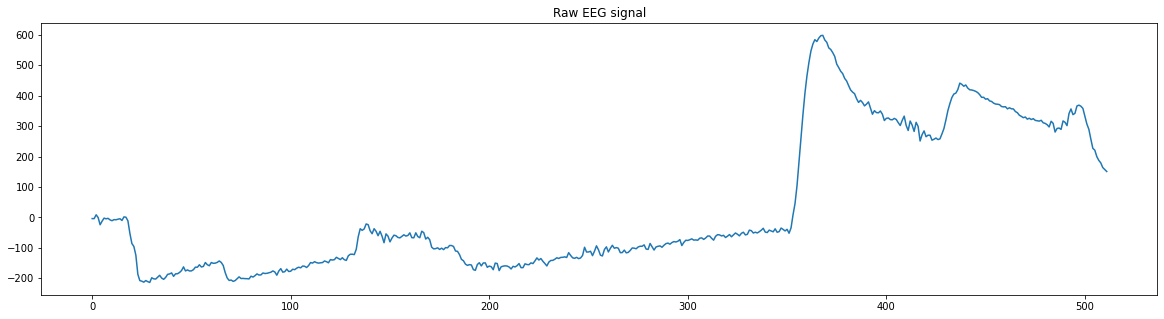

In [8]:
samplenum = 1
plt.figure(figsize=(20,5))
plt.title('Raw EEG signal')
plt.plot(x_raw[samplenum])

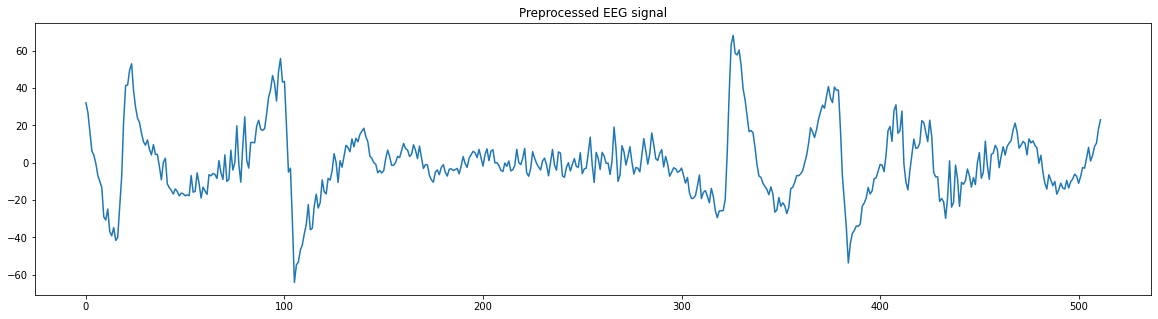

In [9]:
plt.figure(figsize=(20,5))
plt.title('Preprocessed EEG signal')
plt.plot(x[samplenum])

## Splitting samples into training and testing dataset

In [10]:
# caseid
caseids = list(np.unique(c))
random.shuffle(caseids)

# Split dataset into training and testing data
ntest = max(1, int(len(caseids) * 0.2))
caseids_train = caseids[ntest:]
caseids_test = caseids[:ntest]

train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)
x_train = x[train_mask]
y_train = y[train_mask]
x_test = x[test_mask]
y_test = y[test_mask]
b_test = b[test_mask]
c_test = c[test_mask]

print('====================================================')
print('total: {} cases {} samples'.format(len(caseids), len(y)))
print('train: {} cases {} samples'.format(len(np.unique(c[train_mask])), len(y_train)))
print('test {} cases {} samples'.format(len(np.unique(c_test)), len(y_test)))
print('====================================================')

total: 50 cases 433037 samples
train: 40 cases 358430 samples
test 10 cases 74607 samples


## Build model

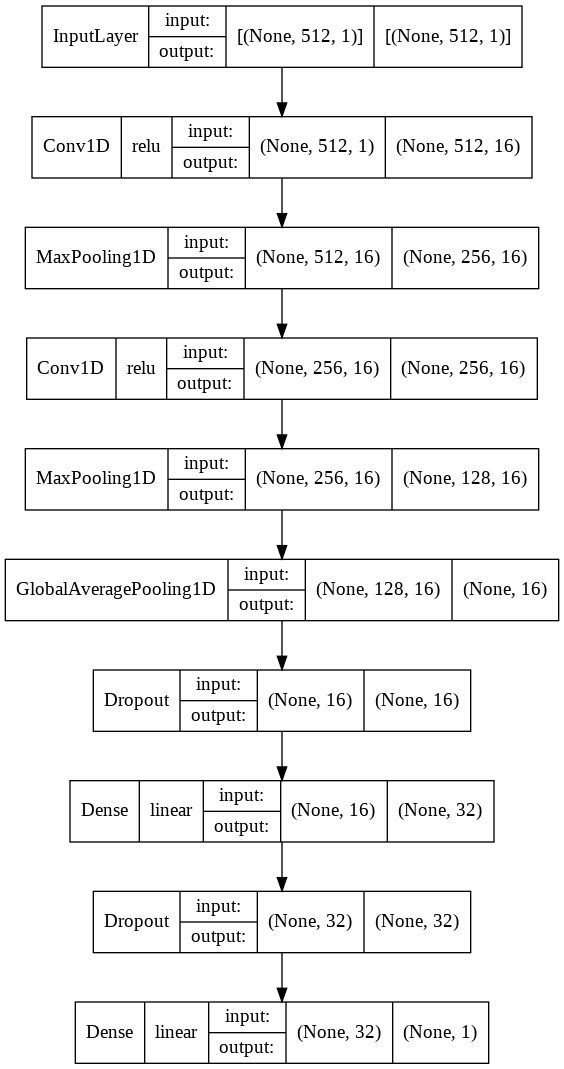

In [11]:
######### TODO 3 #########
import keras.models
import tensorflow as tf
from keras.models import Model
from keras.layers import Layer, LayerNormalization, Dense, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Input, concatenate, multiply, dot, MultiHeadAttention
from keras.callbacks import EarlyStopping, ModelCheckpoint
    
clayer = 2 # Number of convolution layer
fnode = 32 # Number of node in fully connected layer
nfilt = 16 # Number of filter
filtsize = 5 # Filter size
pooltype = 'avg' # Pooling type
poolsize = 2 # Pooling size
droprate = 0.2   # Dropout rate in fully connected layer

odir = '{}cases_{}sec'.format(MAX_CASES, SEGLEN // SRATE)
odir += '_cnn{}+{} filt{} size{} pool{} {} do{}'.format(clayer+1, fnode, nfilt, filtsize, poolsize, pooltype, droprate)
print("============================")
print(odir)
print("============================")

######### TODO 3 : Step 1 #########
# Make model using functional API
out = inp = Input(shape=(x_train.shape[1], 1))

for i in range(clayer):
    out = Conv1D(filters=nfilt, kernel_size=filtsize, padding='same', activation='relu')(out)
    out = MaxPooling1D(poolsize, padding='same')(out)

out = GlobalAveragePooling1D()(out)
out = Dropout(droprate)(out)
out = Dense(fnode)(out)
out = Dropout(droprate)(out)
out = Dense(1)(out)


model = Model(inputs=[inp], outputs=[out])
model.summary()

50cases_4sec_cnn3+32 filt16 size5 pool2 avg do0.2
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 512, 16)           96        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 256, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 256, 16)           1296      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 128, 16)          0         
 1D)                                                             
                                                                 
 global_ave

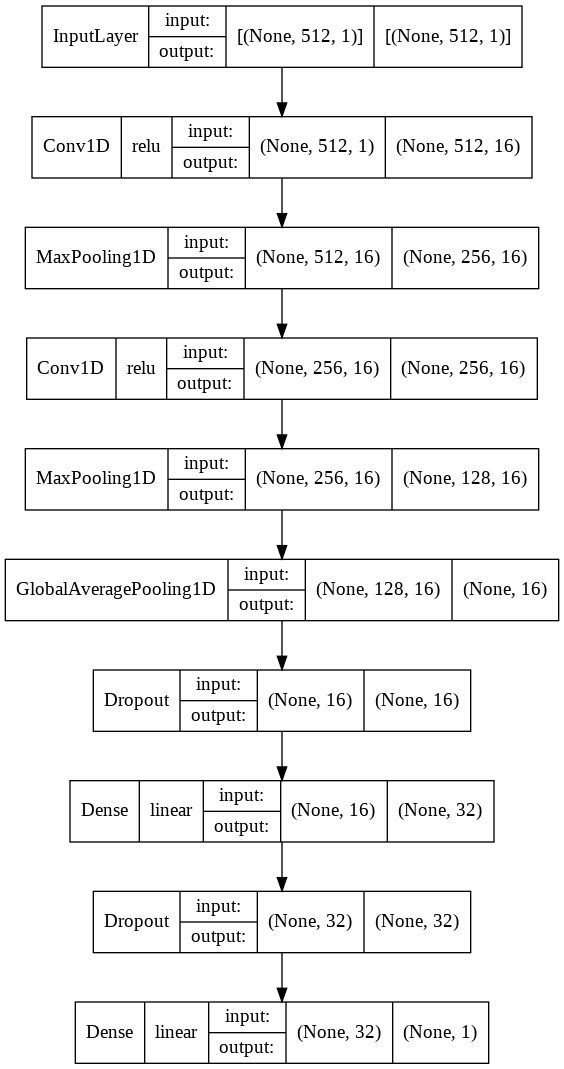

In [12]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

## Model train

In [18]:
######### TODO 4 #########

######### TODO 4 : Step 1 #########
#1 Compile model
# 1) 손실함수: mean absolute error, 2) 평가방법: mean absolute error, 3) 옵티마이저: adam

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

######### TODO 4 : Step 2 #########
#2 Train model
# 1) validation split size: 20%, 2) epoch: 20 이상,  3) 미니배치크기: 1024,  4) Early stopping: 검증셋에서 mae 값이 3번 연속으로 더이상 감소하지 않을 시.
hist = model.fit(x_train[..., None], y_train, validation_split=0.2, epochs=50, batch_size=1024,
                callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')])

Epoch 1/50
281/281 [==============================] - 15s 51ms/step - loss: 0.2645 - mean_absolute_error: 0.2645 - val_loss: 0.1788 - val_mean_absolute_error: 0.1788
Epoch 2/50
281/281 [==============================] - 14s 49ms/step - loss: 0.2098 - mean_absolute_error: 0.2098 - val_loss: 0.1967 - val_mean_absolute_error: 0.1967
Epoch 3/50
281/281 [==============================] - 14s 50ms/step - loss: 0.1968 - mean_absolute_error: 0.1968 - val_loss: 0.2101 - val_mean_absolute_error: 0.2101
Epoch 4/50
281/281 [==============================] - 14s 51ms/step - loss: 0.1859 - mean_absolute_error: 0.1859 - val_loss: 0.2143 - val_mean_absolute_error: 0.2143
Epoch 4: early stopping


##Inference

Total MAE=0.2032, CaseID 21, MAE=0.2112


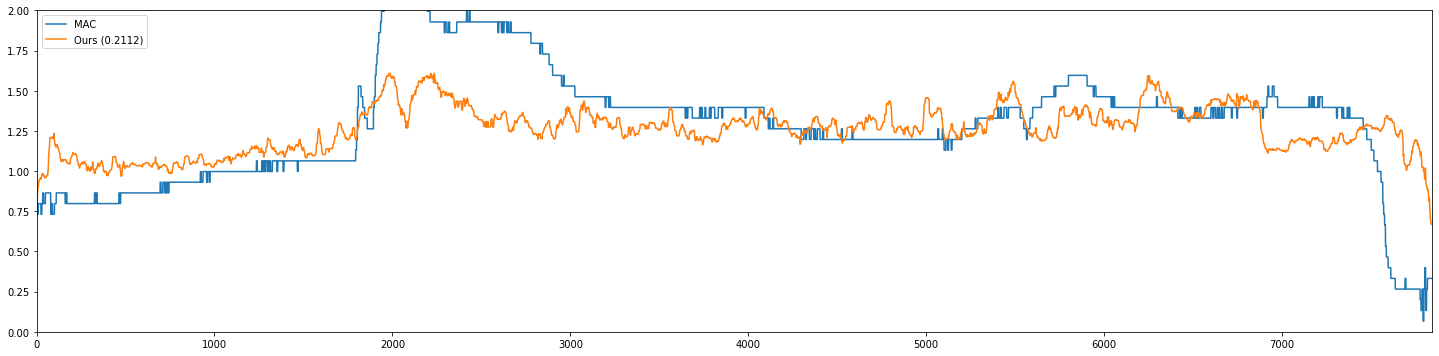

Total MAE=0.2032, CaseID 43, MAE=0.2138


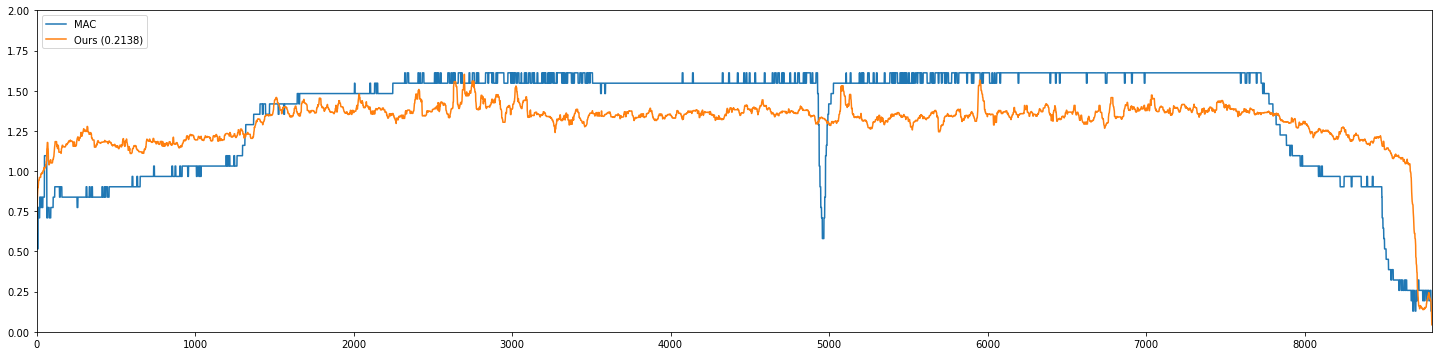

Total MAE=0.2032, CaseID 56, MAE=0.1648


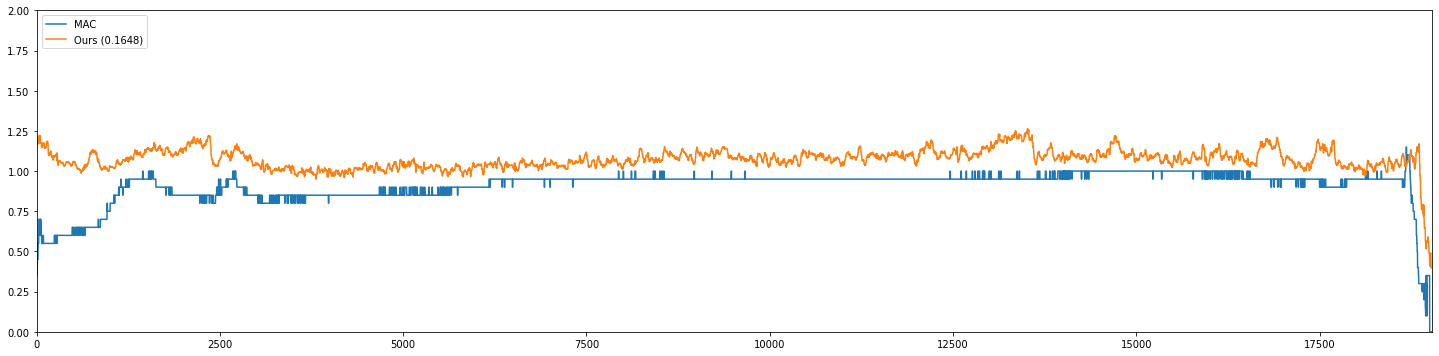

Total MAE=0.2032, CaseID 65, MAE=0.1637


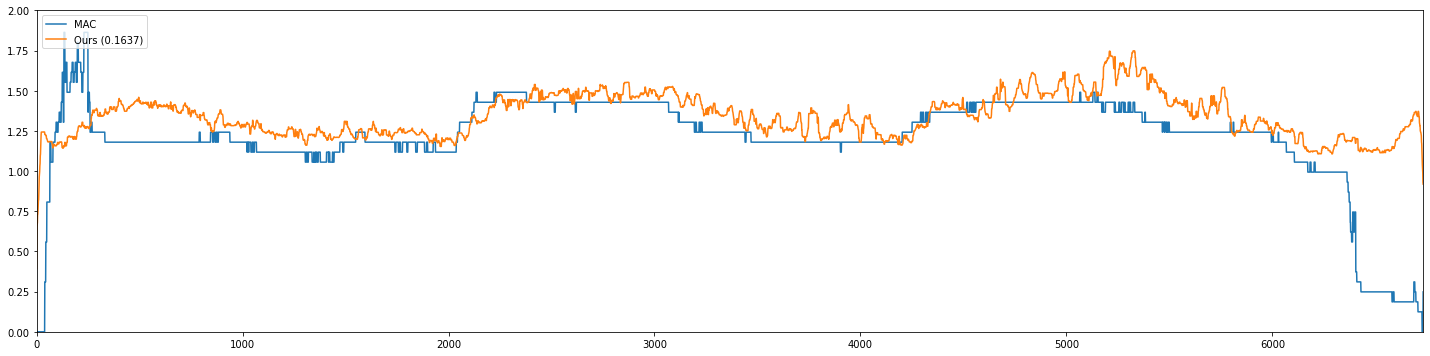

Total MAE=0.2032, CaseID 80, MAE=0.3610


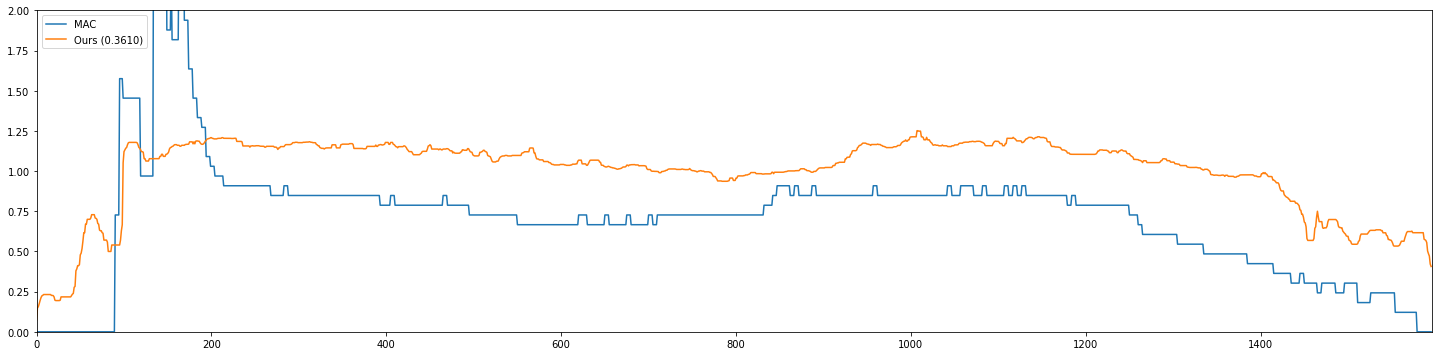

Total MAE=0.2032, CaseID 89, MAE=0.0890


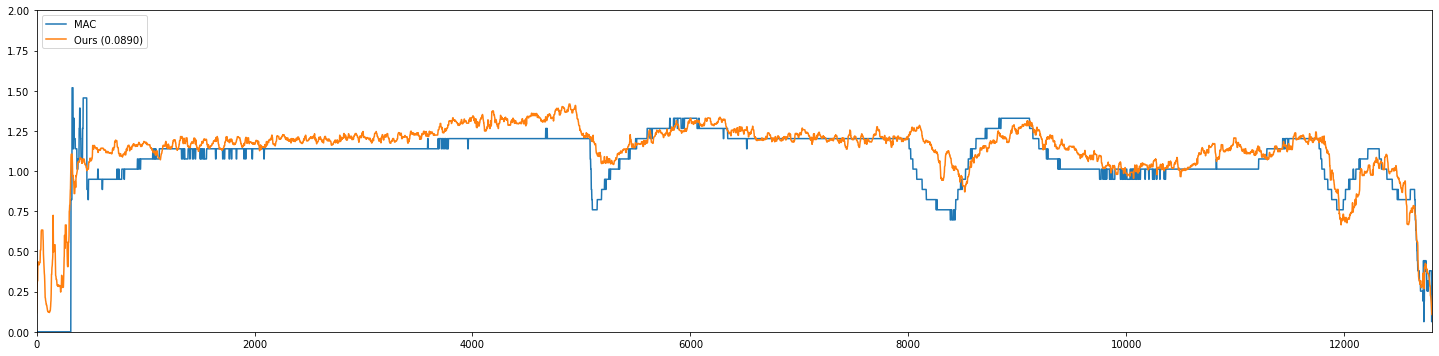

Total MAE=0.2032, CaseID 92, MAE=0.1939


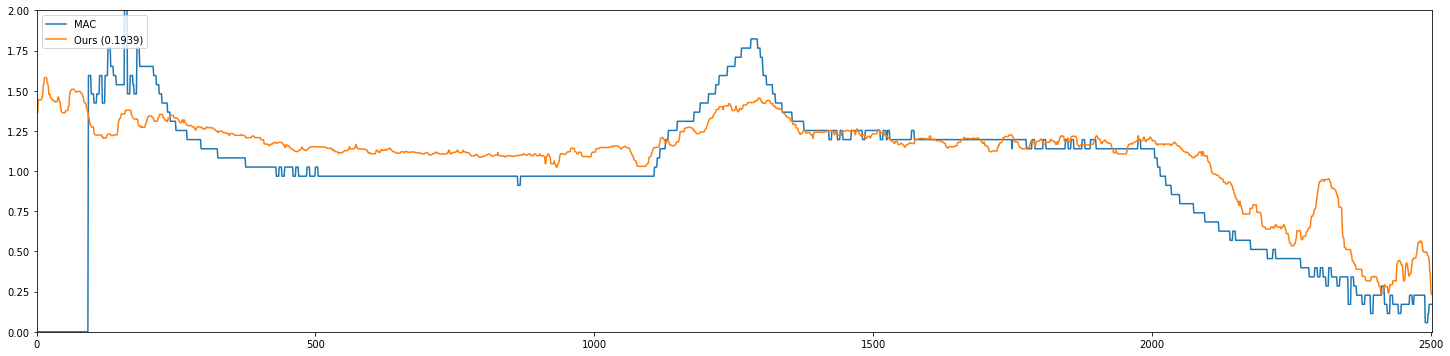

Total MAE=0.2032, CaseID 95, MAE=0.2850


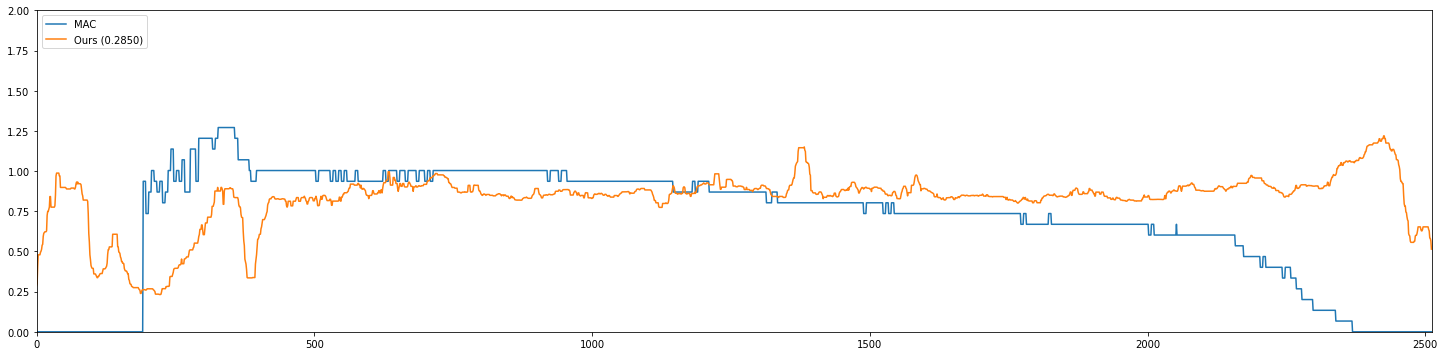

Total MAE=0.2032, CaseID 100, MAE=0.2060


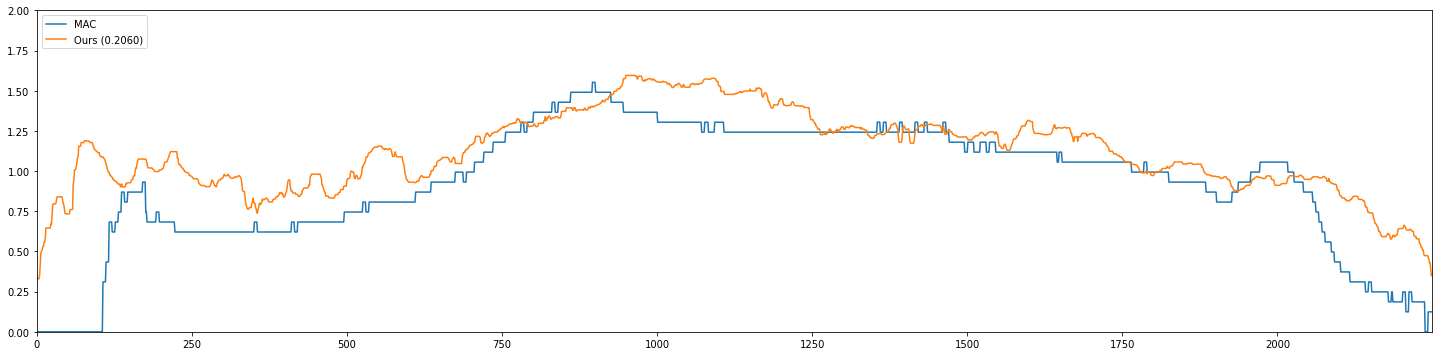

Total MAE=0.2032, CaseID 190, MAE=0.3068


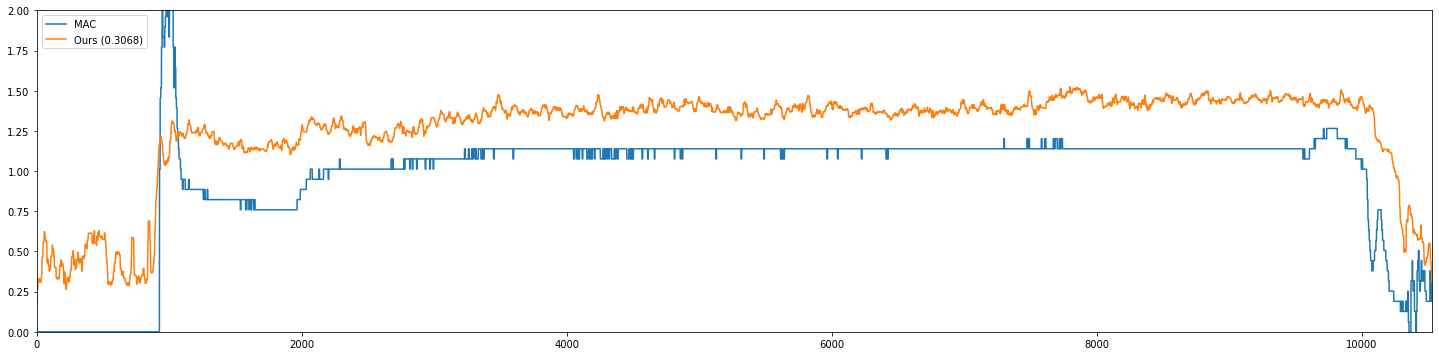

In [19]:
######### TODO 5 #########

######### TODO 5 : Step 1 #########
# Prediction
pred_test = model.predict(x_test[..., None], batch_size=1024).flatten()


######### TODO 5 : Step2 #########
# Calculate the total performance (mean absolute error)
test_mae = np.mean(np.abs(y_test - pred_test))


for caseid in np.unique(c_test):
    case_mask = (c_test == caseid)
    pred_test[case_mask] = scipy.signal.medfilt(pred_test[case_mask], 31)


######### TODO 5 : Step3 #########
# Evaluation
for caseid in np.unique(c_test):
    case_mask = (c_test == caseid)
    case_len = np.sum(case_mask) # Calculate the length of each case
    if case_len == 0:
        continue

    our_mae = np.mean(np.abs(y_test[case_mask] - pred_test[case_mask])) # Calculate the mean absolute error for each case
    print('Total MAE={:.4f}, CaseID {}, MAE={:.4f}'.format(test_mae, caseid, our_mae))

    t = np.arange(0, case_len)
    plt.figure(figsize=(20, 5))
    plt.plot(t, y_test[case_mask], label='MAC') # Plotting MAC 
    plt.plot(t, pred_test[case_mask], label='Ours ({:.4f})'.format(our_mae)) # Plotting predicted MAC
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.xlim([0, case_len])
    plt.ylim([0, 2])
    plt.show()

##  Modeling and Evaluation using Grid Search

In [ ]:
import keras.models
import tensorflow as tf
from keras.models import Model
from keras.layers import Layer, LayerNormalization, Dense, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Input, concatenate, multiply, dot, MultiHeadAttention
from keras.callbacks import EarlyStopping, ModelCheckpoint

BATCH_SIZE = 1024

# Hyperparameters for model architecture
tests = {
    "nfilt" : [16, 32, 64],
    "fnode" : [32, 64, 128],
    "clayer" : [1, 2, 3, 4],
    "droprate" : [0.1, 0.2],
    "filtsize" : [5, 7, 9, 11],
    'poolsize' : [2, 4, 8],
    "pooltype" : ['avg', 'max']
}

# https://keras.io/examples/nlp/text_classification_with_transformer/
keys, values = zip(*tests.items())
permutations_dicts = it.product(*values)
permutations_dicts = list(permutations_dicts)
random.shuffle(permutations_dicts)
for nfilt, fnode, clayer, droprate, filtsize, poolsize, pooltype in permutations_dicts:

    keras.backend.clear_session()
    
    odir = '{}cases_{}sec'.format(MAX_CASES, SEGLEN // SRATE)
    odir += '_cnn{} filt{} size{} pool{} {} do{}'.format(clayer, nfilt, filtsize, poolsize, pooltype, droprate)
    print("============================")
    print(odir)
    print("============================")

    out = inp = Input(shape=(x_train.shape[1], 1))
    # Initialize cnn layer
    out = Conv1D(filters=nfilt, kernel_size=filtsize, padding='same')(out)
    # Multilayer conv 
    for i in range(clayer):
        out = Conv1D(filters=nfilt, kernel_size=filtsize, padding='same', activation='relu')(out)
        out = MaxPooling1D(poolsize, padding='same')(out)
    if pooltype == "avg":
        out = GlobalAveragePooling1D()(out)
    else:
        out = GlobalMaxPooling1D()(out)

    if droprate:
        out = Dropout(droprate)(out)
    out = Dense(fnode)(out)
    if droprate:
        out = Dropout(droprate)(out)
    out = Dense(1)(out)


    model = Model(inputs=[inp], outputs=[out])
    model.summary()
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    hist = model.fit(x_train[..., None], y_train, validation_split=0.2, epochs=10, batch_size=BATCH_SIZE,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='auto')])

    # Prediction
    pred_test = model.predict(x_test[..., None], batch_size=BATCH_SIZE).flatten()

    # Calculate the performance
    test_mae = np.mean(np.abs(y_test - pred_test))
    for caseid in np.unique(c_test):
        case_mask = (c_test == caseid)
        pred_test[case_mask] = scipy.signal.medfilt(pred_test[case_mask], 31)

    # Evaluation
    for caseid in np.unique(c_test):
        case_mask = (c_test == caseid)
        case_len = np.sum(case_mask)
        if case_len == 0:
            continue

        our_mae = np.mean(np.abs(y_test[case_mask] - pred_test[case_mask]))
        print('Total MAE={:.4f}, CaseID {}, MAE={:.4f}'.format(test_mae, caseid, our_mae))

        t = np.arange(0, case_len)
        plt.figure(figsize=(20, 5))
        plt.plot(t, y_test[case_mask], label='MAC')  # 측정 결과 
        plt.plot(t, pred_test[case_mask], label='Ours ({:.4f})'.format(our_mae))
        plt.legend(loc="upper left")
        plt.tight_layout()
        plt.xlim([0, case_len])
        plt.ylim([0, 2])
        plt.show()